<a href="https://colab.research.google.com/github/bghadge/Computer-Vision/blob/master/10_Optical_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EECS 504 PS10: Optical Flow**


# Overview

In this problem set, You will implemente the Lucas-Kanade (LK) optical flow algorithm for estimating dense motion between a pair of images. Since some of the motions might be too large for the Taylor approximation of the LK step, we will apply the algorithm in a coarse-to-fine manner. 


# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [0]:
%matplotlib inline
import cv2
import scipy.ndimage
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import imageio
import math

In [0]:
%%capture
! wget -O car1.jpg "https://drive.google.com/uc?export=download&id=14jfYyCRSeaCe2tdvNJd6lkG6C-DWzn2s"
! wget -O car2.jpg "https://drive.google.com/uc?export=download&id=1MNR0TSXPT1yxKaiOvBHforYHvd7Lr7jD"

# 10.0 Visualize Input Images
**You could also visualize these as animaget GIFs, by selecting files in the sidebar on the left.**

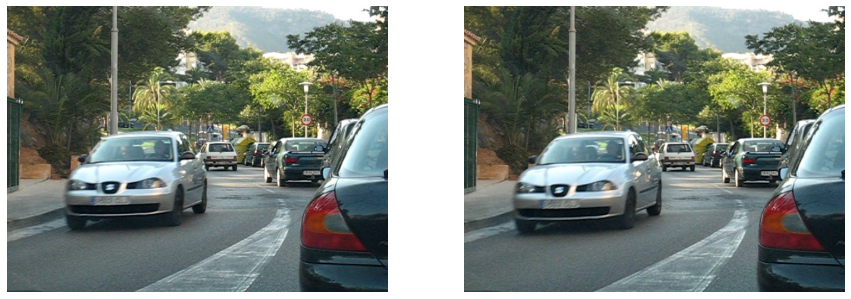

In [0]:
# load images
img1 = cv2.cvtColor(cv2.imread('car1.jpg'),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('car2.jpg'),cv2.COLOR_BGR2RGB)

def plot_imgs(img1, img2, name):
    fig, ax = plt.subplots(1, 2, figsize=(15, 20))
    for a in ax:
      a.set_axis_off()
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    images = [img1, img2]
    imageio.mimsave(name, images, fps=2)

plot_imgs(img1, img2, 'input.gif')
# cv2_imshow(cv2.imread('car1.jpg'))

# 10.1 Lucas-Kanade (LK) optical flow algorithm
Implement the function: 

```
u,v,warpI2 = lucas_kanade(I1,I2,u0,v0,winsize,medfiltSize,nIterations)
```
that receives as input two images I1 and I2 and initial flow estimates (u0,v0), and computes
the optical flow field (u,v) from image I2 to I1 using the Lucas-Kanade algorithm. 


In [0]:
def warp_flow_fast(im2, u, v):
    """ 
    im2 warped according to (u,v).
    This is a helper function that is used to warp an image to make it match another image 
    (in this case, I2 is warped to I1).
    Assumes im1[y, x] = im2[y + v[y, x], x + u[y, x]] 
    """
    # this code is confusing because we assume vx and vy are the negative
    # of where to send each pixel, as in the results by ce's siftflow code
    y, x = np.mgrid[:im2.shape[0], :im2.shape[1]]
    dy = (y + v).flatten()[np.newaxis, :]
    dx = (x + u).flatten()[np.newaxis, :]
    # this says: a recipe for making im1 is to make a new image where im[y, x] = im2[y + flow[y, x, 1], x + flow[y, x, 0]]
    return np.concatenate([scipy.ndimage.map_coordinates(im2[..., i], np.concatenate([dy, dx])).reshape(im2.shape[:2] + (1,)) \
                            for i in range(im2.shape[2])], axis = 2)

In [0]:
# You may find it helpful to put helper functions here
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== #

# ============== END OF CODE ================= # 
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#

In [0]:
def get_derivatives(I1,I2):
    '''
    Calculate Ixx, Iyy, Ixy, Ixt, Iyt. 
    '''
    # To increase robustness, over the method presented in the lecture notes:
    #      1. Blur the images using a Gaussian kernel to I1, I2 with kernel_size = 5, sigma = 1.
    #         before computing derivatives.
    #      2. Computing spatial derivatives Ix, Iy and It.
    #         For the spatial derivatives, please use the gradient filter [1, -8, 0, 8, -1]/12
    #      3. Get Ixx, Iyy, Ixy, Ixt, Iyt, then average over three channel 
    

    # Blur the images
    
    blurredI1 = cv2.GaussianBlur(I1, (5,5), 1)
    blurredI2 = cv2.GaussianBlur(I2, (5,5), 1)

    # Computing spatial derivatives

    k = 1/12.*np.array([1, -8, 0, 8, -1])
    kx = np.array([[0,0,0,0,0],[0,0,0,0,0],[1,-8,0,8,-1],[0,0,0,0,0],[0,0,0,0,0]]) / 12.0
    ky = np.array([[0,0,1,0,0],[0,0,-8,0,0],[0,0,0,0,0],[0,0,8,0,0],[0,0,-1,0,0]]) / 12.0

    Ix = np.zeros_like(I2)
    Iy = np.zeros_like(I2)
    for i in range(3):
      Ix[:,:,i] = scipy.signal.correlate2d(blurredI2[:,:,i],kx,mode='same')
      Iy[:,:,i] = scipy.signal.correlate2d(blurredI2[:,:,i],ky,mode='same')
    It = I2 - I1

    # cv2_imshow(Ix)
    # cv2_imshow(Iy)

    Ixx = np.mean(Ix*Ix, axis=2, dtype=np.float32)
    Iyy = np.mean(Iy*Iy, axis=2, dtype=np.float32)
    Ixy = np.mean(Ix*Iy, axis=2, dtype=np.float32)
    Ixt = np.mean(Ix*It, axis=2, dtype=np.float32)
    Iyt = np.mean(Iy*It, axis=2, dtype=np.float32)

    return Ixx, Iyy, Ixy, Ixt, Iyt

def lucas_kanade(I1,I2,u,v,winsize,medfiltSize,nIterations):
    '''
    Lucas-Kanade algorithm. 
    Input:
        winsize - half the patch size, 
        medfiltSize - the size of the window for the spatial median filter,
        nIterations - the number of flow refinement iterations. warpI2 is the image I2 warped according to (u,v).
    Return: 
      out: M/2 x N/2 x C 
    '''
    # warp I2 according to (u,v)
    warpI2 = warp_flow_fast(I2,u,v)

    for i in range(nIterations):
        # compute derivatives
        Ixx, Iyy, Ixy, Ixt, Iyt = get_derivatives(I1,warpI2)

        # Sum the loss over every pixel in a small window.
        # Note that, unlike in class, we weigh the contribution of each pixel
        # based on its distance to the center using a Gaussian filter.
        a = gaussian_blur(Ixx, winsize*2+1, winsize/2.) + 0.001
        b = gaussian_blur(Ixy, winsize*2+1, winsize/2.)
        c = gaussian_blur(Iyy, winsize*2+1, winsize/2.) + 0.001
        d = gaussian_blur(Ixt, winsize*2+1, winsize/2.)
        e = gaussian_blur(Iyt, winsize*2+1, winsize/2.)

        # solve the 2x2 linear system at every pixel
        det = a * c - b**2. + np.finfo(float).eps
        du = -(c * d - b * e) / det
        dv = -(-b * d + a * e) / det
    
        # update the flow field and warp image
        u = u + du
        v = v + dv
        
        # median filtering using this to remove outliers)
        if medfiltSize > 0:
            u = signal.medfilt2d(u, (medfiltSize, medfiltSize))
            v = signal.medfilt2d(v, (medfiltSize, medfiltSize))

        # Complete the rest part of lucas_kanade 

        warpI2 = warp_flow_fast(I2,u,v)
    return u, v, warpI2

In [0]:
# n = np.arange(4).reshape(2,2)
# k = np.arange(4).reshape(2,2)
# print(n*k)
# print(np.dot(n,k))
# kx = np.array([[0,0,0,0,0],[0,0,0,0,0],[1,8,0,-8,-1],[0,0,0,0,0],[0,0,0,0,0]]) / 12.0
# kx
# cv2_imshow(cv2.imread('car1.jpg'))
# cv2_imshow(cv2.imread('car2.jpg'))
# im1 = cv2.imread('car1.jpg')
# im2 = cv2.imread('car2.jpg')
# im1 = img1
# im2 = img2
# row, col, ch = im2.shape
# # print(ch)
# u = np.zeros((row,col))
# v = np.zeros_like(u)
# k,l,warp = lucas_kanade(im1,im2,u,v,3,11,5)
# plot_imgs(im1,warp,'sd.gif')

In [0]:
# u = np.zeros((row,col))
# v = np.zeros_like(u)
# k,l,warp = lucas_kanade(im1,im2,u,v,3,11,1)
# plot_imgs(im1,warp,'sd.gif')

# 10.2 Coarse-to-Fine Scheme of Lucas-Kanade
 Implement the function


```
u,v,warpI2 = coarse2fine_lk(I1,I2,nlevels)
```
that receives as input two images I1 and I2, and computes the optical flow (u,v) from I2 to I1 using the coarse-to-fine scheme of Lucas-Kanade (Algorithm 1) using your function from part 10.1.






***Algorithm 1 Coarse-to-Fine-LK(I1, I2,k)***


1.   Build k-level Gaussian pyramids $G_1,G_2$ for $I_1, I_2$
2.   Find the optical flow field ($u_k,v_k$) from $G^k_2$ to $G^k_1$ at the coarsest pyramid level k using
  the Lucas-Kanade algorithm
3. Upsample the flow field for level k−1,and transform $G^{k−1}_2$ towards $G^{k−1}_1$ using ($u_{k−1},v_{k−1}$)
4. Update the optical flow estimation ($u_{k−1},v_{k−1}$) at level k − 1
5. Repeat 3–4 for levels k−2, k−3, ..., 1 

In [0]:
def gaussian_blur(img, kernel, sigma):
    kernel = cv2.getGaussianKernel(kernel, sigma)
    kernel = (kernel * kernel.T)
    img_ = img.copy()
    if img.ndim == 3:
        for i in range(3):  
            img_[:,:,i] = signal.correlate2d(img[:,:,i], kernel, 'same')
    else:
        img_[:,:] = signal.correlate2d(img[:,:], kernel, 'same')
    return img_

def pyr_down(p, kernel_size=3, sigma=0.8):
    '''
    Downsample the pyramid image to get the upper level. 
    Input:
      p: M x N x C array
    Return: 
      out: M/2 x N/2 x C 
    '''
    p_ = p.copy()
    out = gaussian_blur(p_, kernel_size, sigma)
    return cv2.resize(out, (int(p.shape[1]/2), int(p.shape[0]/2)), interpolation = cv2.INTER_CUBIC)

def buildGPyramid(im,nlevels):
    '''
    building pyramid of nlevels
    '''
    pyrd = []
    pyrd.append(im)
    for i in range(1,nlevels):
        pyrd.append(pyr_down(pyrd[-1]))
    return pyrd

In [0]:
def coarse2fine_lk(im1,im2,nlevels,winsize,medfiltsize,nIterations):
    # building pyramid
    pyrd1 = buildGPyramid(im1,nlevels)    # last image in the pyramid is the coarse one
    pyrd2 = buildGPyramid(im2,nlevels)

    # compute from coarse level to fine level
    # Hint: Initialze u,v with all zeros
        
    p2_row, p2_col, p2_ch = pyrd2[-1].shape
    u = np.zeros((p2_row, p2_col))
    v = np.zeros_like(u)
    
    for i in range(1,nlevels):
      # print('ushape',u.shape)
      newu,newv,warpI2 = lucas_kanade(pyrd1[-i], pyrd2[-i],u,v,winsize,medfiltsize,nIterations)
      # print('new shape',newu.shape)
      u = cv2.resize(newu, dsize=(pyrd2[-i-1].shape[1], pyrd2[-i-1].shape[0]), interpolation=cv2.INTER_CUBIC)
      v = cv2.resize(newv, dsize=(pyrd2[-i-1].shape[1], pyrd2[-i-1].shape[0]), interpolation=cv2.INTER_CUBIC)

    return u, v, warpI2


# 10.3 Results
Run the algorithm on the car image pair supplied with the code. Report the resulting optical flow image and the warped car2 image.

**You could also visualize these as animaget GIFs, by selecting files in the sidebar on the left.**


In [0]:
def make_colorwheel():
    '''
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0,RY)/RY)
    col = col+RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.arange(0,YG)/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.arange(0,GC)/GC)
    col = col+GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.arange(CB)/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.arange(0,BM)/BM)
    col = col+BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.arange(MR)/MR)
    colorwheel[col:col+MR, 0] = 255
    return colorwheel


def flow_compute_color(u, v, convert_to_bgr=False):
    '''
    Applies the flow color wheel to (possibly clipped) flow components u and v.
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param u: np.ndarray, input horizontal flow
    :param v: np.ndarray, input vertical flow
    :param convert_to_bgr: bool, whether to change ordering and output BGR instead of RGB
    :return:
    '''

    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)

    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]

    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u)/np.pi

    fk = (a+1) / 2*(ncols-1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0

    for i in range(colorwheel.shape[1]):
        tmp = colorwheel[:,i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1-f)*col0 + f*col1

        idx = (rad <= 1)
        col[idx]  = 1 - rad[idx] * (1-col[idx])
        col[~idx] = col[~idx] * 0.75   # out of range?

        # Note the 2-i => BGR instead of RGB
        ch_idx = 2-i if convert_to_bgr else i
        flow_image[:,:,ch_idx] = np.floor(255 * col)

    return flow_image


def flow_to_color(flow_uv, clip_flow=None, convert_to_bgr=False):
    '''
    Expects a two dimensional flow image of shape [H,W,2]
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param flow_uv: np.ndarray of shape [H,W,2]
    :param clip_flow: float, maximum clipping value for flow
    :return:
    '''

    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'

    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)

    u = flow_uv[:,:,0]
    v = flow_uv[:,:,1]

    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)

    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)

    return flow_compute_color(u, v, convert_to_bgr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


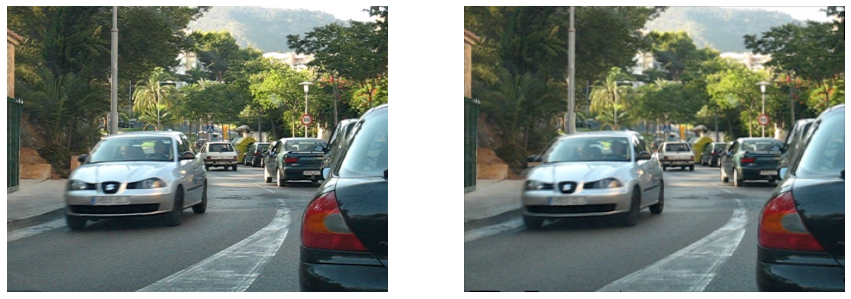

In [0]:
#rescales the image from integer data types to the range [0, 1]
img1_norm = cv2.normalize(img1.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
img2_norm = cv2.normalize(img2.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# set parameters

# The parameters in that script are set to values which we found to produce 
# good results.
nlevels = 5
winsize = 3
medfiltsize = 11
nIterations = 50

# use coarse to fine lucas kanade to obtain optical flow field
u, v, warpI2 = coarse2fine_lk(img1_norm,img2_norm,nlevels,winsize,medfiltsize,nIterations)

plot_imgs(img1, warpI2, 'results.gif')


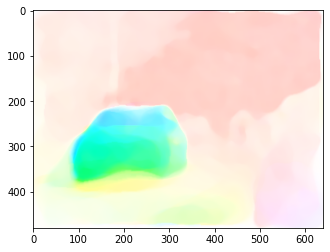

In [0]:
# optical flow visualization
result = flow_to_color(np.array([u, v]).transpose(1,2,0))
plt.imshow(result)

# 10.4 Warping
Implement warp_flow in this section.

Your solution should perform inverse warping and bilinear interpolation.

You may implement it using nested for loops or with numpy primitives;

You should not use built-in warping or interpolationfunctions (such as those in scipy or OpenCV). 

Handle out-of-bounds values by zeropadding

In [0]:
def bilinear(img,px,py):
  px_low = math.floor(px)
  px_high = math.ceil(px)
  py_low = math.floor(py)
  py_high = math.ceil(py)

  # pad image
  img = np.pad(img,2,'constant')

  # py_low constant
  pxl_val = (px_high - px)/(px_high - px_low)*img[px_low,py_low] + (px_low - px)/(px_low - px_high)*img[px_high,py_low]

  # py_high
  pxh_val = (px_high - px)/(px_high - px_low)*img[px_low,py_high] + (px_low - px)/(px_low - px_high)*img[px_high,py_high]

  # py
  pxy = (py_high - py)/(py_high - py_low)*pxl_val + (py_low - py)/(py_low - py_high)*pxh_val

  return pxy

In [0]:
def warp_flow(I2, u, v):
    """ 
    im2 warped according to (u,v)
    """
    inv_warp = np.zeros_like(I2)

    for i in range(inv_warp.shape[0]):
      for j in range(inv_warp.shape[1]):
        row_pos = i+u[i,j]
        col_pos = j+v[i,j]
        if isinstance(row_pos,int) and isinstance(col_pos,int) and row_pos <= I2.shape[0] and col_pos <= I2.shape[1] :
          inv_warp[i,j,:] = I2[i+u[i,j], j+v[i,j], :]
        else:
          inv_warp[i,j,0] = bilinear(I2[:,:,0], row_pos, col_pos)
          inv_warp[i,j,1] = bilinear(I2[:,:,1], row_pos, col_pos)
          inv_warp[i,j,2] = bilinear(I2[:,:,2], row_pos, col_pos)

    return inv_warp
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


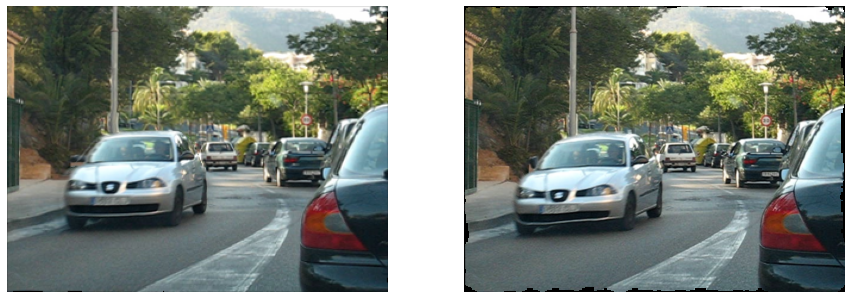

In [0]:
# Compare the result with warp_flow_fast
plot_imgs(warpI2, warp_flow(img2_norm, u, v), 'warp_flow.gif')